# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
import scipy

In [ ]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [ ]:
df["sales_channel"].value_counts()

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64

In [ ]:
mapping = {
    "Internet": 1,
    "Mobile": 2
}

df["sales_channel"] = df["sales_channel"].map(mapping)

In [ ]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,1,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,1,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,1,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,1,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df['trip_type'].value_counts()

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

In [ ]:
mapping = {
    "RoundTrip": 1,
    "OneWay": 2,
    "CircleTrip": 3
}

df["trip_type"] = df["trip_type"].map(mapping)

In [ ]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,1,1,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,1,1,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,1,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,1,1,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [ ]:
# let's have a look at how many labels each variable has

for col in df[['route','booking_origin']]:
    print(col, ': ', len(df[col].unique()), ' labels')

route :  799  labels
booking_origin :  104  labels


In [ ]:
# let's examine how many columns we will obtain after one hot encoding these variables
pd.get_dummies(df, drop_first=True).shape

(50000, 913)

In [ ]:
# let's find the top 10 most frequent categories for the column route

df.route.value_counts().sort_values(ascending=False).head(20)

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
ICNSYD     695
DMKPER     679
DPSICN     666
DMKOOL     655
MELPEN     649
MELTPE     644
SGNSYD     614
DMKSYD     532
COKSYD     511
COKMEL     474
CMBMEL     465
HNDPEN     442
PENPER     437
DPSPVG     417
CGKICN     414
Name: route, dtype: int64

In [ ]:
# let's make a list with the most frequent categories of the column route

top_10_routes = [y for y in df.route.value_counts().sort_values(ascending=False).head(10).index]
top_10_routes

['AKLKUL',
 'PENTPE',
 'MELSGN',
 'ICNSIN',
 'DMKKIX',
 'ICNSYD',
 'DMKPER',
 'DPSICN',
 'DMKOOL',
 'MELPEN']

In [ ]:
top_10_origin = [y for y in df.booking_origin.value_counts().sort_values(ascending=False).head(10).index]
top_10_origin

['Australia',
 'Malaysia',
 'South Korea',
 'Japan',
 'China',
 'Indonesia',
 'Taiwan',
 'Thailand',
 'India',
 'New Zealand']

In [ ]:
# get whole set of dummy variables, for all the categorical variables

def one_hot_encoding_top_x(df, variable, top_x):
    # function to create the dummy variables for the most frequent labels
    # we can vary the number of most frequent labels that we encode
    
    for label in top_x:
        df[variable+'_'+label] = np.where(df[variable]==label, 1, 0)

one_hot_encoding_top_x(df, 'route', top_10_routes)

In [ ]:
one_hot_encoding_top_x(df, 'booking_origin', top_10_origin)

In [ ]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,booking_origin_Australia,booking_origin_Malaysia,booking_origin_South Korea,booking_origin_Japan,booking_origin_China,booking_origin_Indonesia,booking_origin_Taiwan,booking_origin_Thailand,booking_origin_India,booking_origin_New Zealand
0,2,1,1,262,19,7,6,AKLDEL,New Zealand,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,112,20,3,6,AKLDEL,New Zealand,0,...,0,0,0,0,0,0,0,0,0,1
2,2,1,1,243,22,17,3,AKLDEL,India,1,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,96,31,4,6,AKLDEL,New Zealand,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,1,68,22,15,3,AKLDEL,India,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_passengers              50000 non-null  int64  
 1   sales_channel               50000 non-null  int64  
 2   trip_type                   50000 non-null  int64  
 3   purchase_lead               50000 non-null  int64  
 4   length_of_stay              50000 non-null  int64  
 5   flight_hour                 50000 non-null  int64  
 6   flight_day                  50000 non-null  int64  
 7   wants_extra_baggage         50000 non-null  int64  
 8   wants_preferred_seat        50000 non-null  int64  
 9   wants_in_flight_meals       50000 non-null  int64  
 10  flight_duration             50000 non-null  float64
 11  booking_complete            50000 non-null  int64  
 12  route_AKLKUL                50000 non-null  int64  
 13  route_PENTPE                500

In [ ]:
df = df.drop(['route', 'booking_origin'], axis=1)

In [ ]:
# train test splitting

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)

print("Length of training data:", len(train_set))
print("Length of testing data:", len(test_set))
print("Length of total data:", len(df))

Length of training data: 37500
Length of testing data: 12500
Length of total data: 50000


In [ ]:
# correlations

train_df = train_set.copy()
cols = train_df.drop(['booking_complete'], axis=1)
correlations = [train_df['booking_complete'].corr(train_df[f]) for f in cols]

In [ ]:
corr_matrix = pd.DataFrame({'attributes': df.columns.drop(['booking_complete']), 'correlation': correlations})
corr_matrix.sort_values(ascending=False, by='correlation')

,attributes,correlation
22,booking_origin_Malaysia,0.225782
12,route_PENTPE,0.111121
26,booking_origin_Indonesia,0.065094
7,wants_extra_baggage,0.062835
8,wants_preferred_seat,0.049717
28,booking_origin_Thailand,0.047808
11,route_AKLKUL,0.045513
25,booking_origin_China,0.040856
15,route_DMKKIX,0.035695
0,num_passengers,0.031314


In [ ]:
def plot_corr_dataframe(df, y_label):
    color = 'brown'
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    plt.ylabel(y_label)
    
    ax = corr_matrix.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(corr_matrix.index)
    ax.set_xticklabels(corr_matrix.attributes, rotation=75)
    plt.show()

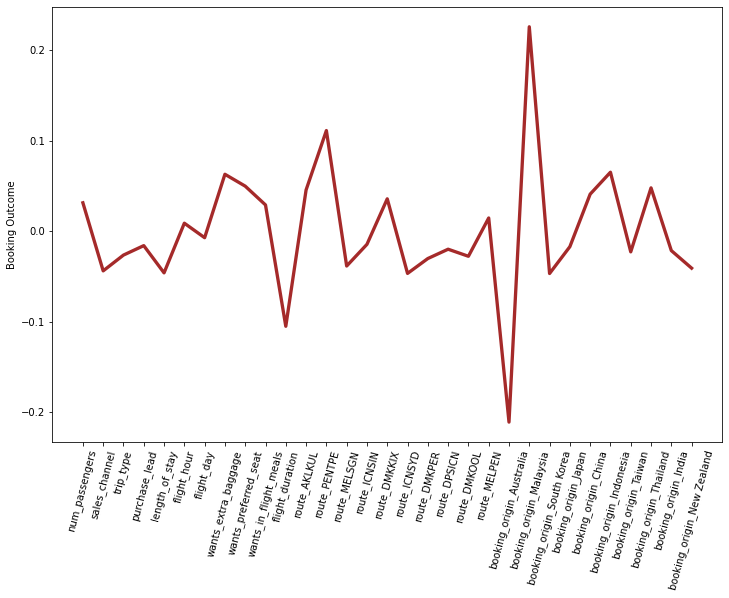

In [ ]:
plot_corr_dataframe(corr_matrix, 'Booking Outcome')

In [ ]:
# split into feature and target

y_train = train_set['booking_complete']
X_train = train_set.drop(['booking_complete'], axis=1)
y_test = test_set['booking_complete']
X_test = test_set.drop(['booking_complete'], axis=1)

In [ ]:
xgb = XGBClassifier(verbosity = 1)
xgb.fit(X_train, y_train)

XGBClassifier()

In [ ]:
# make predictions for test data

y_pred = xgb.predict(X_train)
predictions = [round(value) for value in y_pred]

In [ ]:
# evaluate predictions

accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.04%


In [ ]:
# accuracy on test set

y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.38%


In [ ]:
# cross validation

scores = cross_val_score(xgb, X_train, y_train, cv=10)
print("Scores: ", scores)

Scores:  [0.84906667 0.8504     0.84906667 0.85093333 0.848      0.85173333
 0.8488     0.84986667 0.85013333 0.85173333]


In [ ]:
i = 1
for score in scores:
  print("Score", i , ": %.2f%%" % (score*100.0))
  i += 1

Score 1 : 84.91%
Score 2 : 85.04%
Score 3 : 84.91%
Score 4 : 85.09%
Score 5 : 84.80%
Score 6 : 85.17%
Score 7 : 84.88%
Score 8 : 84.99%
Score 9 : 85.01%
Score 10 : 85.17%


In [ ]:
score_mean = np.mean(scores)
score_mean

0.8499733333333331

In [ ]:
confidence = 0.95  
rounds = 5
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df= rounds - 1)

sd = np.std(scores, ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = score_mean - ci_length
ci_upper = score_mean + ci_length

print(ci_lower, ci_upper)

0.8484109038514449 0.8515357628152214


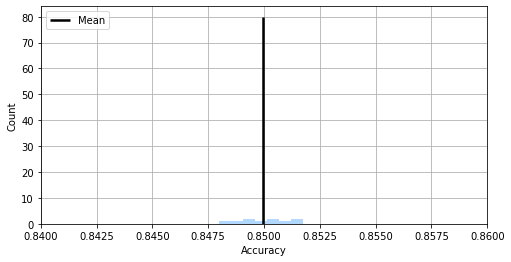

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.vlines(score_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.hist(
    scores, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.84, 0.86])

plt.legend(loc="upper left")
plt.grid()
plt.show()

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[10598,    50],
       [ 1778,    74]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


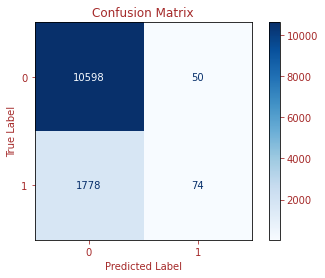

In [ ]:
color = 'brown'
matrix = plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10648
           1       0.60      0.04      0.07      1852

    accuracy                           0.85     12500
   macro avg       0.73      0.52      0.50     12500
weighted avg       0.82      0.85      0.80     12500

